# Siamese Network
------------------------------

Constrastive loss: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf

Siamese Network for one shot learning: https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

b-vector
------------------------------

Siamese network는 feature의 distance를 가지고 최종 feature vector로 사용한다.

하지만 이런 inductive bias를 넣지않고 그냥 feature를 집어넣는다면?

--> 아쉽게도... 너무 freedom이 커져서.. 학습이 되지 않는다.

그래서 추가로 해보려는 게.. b-vector이다.

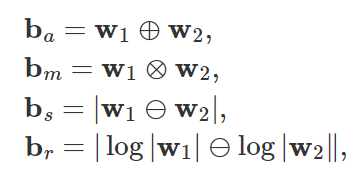

### Environment

In [1]:
%load_ext autoreload
%autoreload 2
%pylab
%matplotlib inline

import pandas as pd
import pickle
import numpy as np
import sys
import os

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.append('/host/projects/sv_experiments')
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

### Configuration

In [3]:
from sv_system.utils.parser import set_train_config
import easydict

# datasets
# voxc1_fbank_xvector
# gcommand_fbank_xvector

args = easydict.EasyDict(dict(dataset="voxc1_fbank_xvector",
                              input_frames=100, splice_frames=[50, 100], stride_frames=1, input_format='fbank',
                              cuda=True,
                              lrs=[0.1, 0.01], lr_schedule=[20], seed=1337,
                              no_eer=False,
                              batch_size=128,
                              arch="tdnn_conv", loss="softmax",
                              n_epochs=50
                             ))
config = set_train_config(args)

### Dataset

In [4]:
import torch.utils.data as data

class embedDataset(data.Dataset):
    def __init__(self, embeds, labels):
        super().__init__()
        self.embeds = embeds
        self.labels = labels
        
    def __getitem__(self, index):
        
        return self.embeds[index], self.labels[index]
    
    def __len__(self):
        
        return self.embeds.shape[0]

In [5]:
def embedToDataset(embeds, key_df):
    labels = key_df.label.tolist()
    dataset = embedDataset(embeds, labels)
    
    return dataset, embeds.shape[1], len(key_df.label.unique())

In [6]:
def key2df(keys):
    key_df = pd.DataFrame(keys, columns=['key'])
    key_df['spk'] = key_df.key.apply(lambda x: x.split("-")[0])
    key_df['label'] = key_df.groupby('spk').ngroup()
    key_df['origin'] = key_df.spk.apply(lambda x: 'voxc2' if x.startswith('id') else 'voxc1')
    
    return key_df

In [7]:
trial = pd.read_pickle("/host/projects/sv_experiments/dataset/dataframes/voxc1/voxc_trial.pkl")

In [8]:
# si_keys = pickle.load(open("/host/projects/sv_experiments/embeddings/voxc12/xvectors/xvectors_tdnn7b/train_feat/key.pkl", "rb"))
# si_embeds = np.load("/host/projects/sv_experiments/embeddings/voxc12/xvectors/xvectors_tdnn7b/train_feat/feat.npy")

# sv_keys = pickle.load(open("/host/projects/sv_experiments/embeddings/voxc12/xvectors/xvectors_tdnn7b/test_feat/key.pkl", "rb"))
# sv_embeds = np.load("/host/projects/sv_experiments/embeddings/voxc12/xvectors/xvectors_tdnn7b/test_feat/feat.npy")

import kaldi_io

si_keys = []
si_embeds = []
for k,v in kaldi_io.read_vec_flt_ark("../../embeddings/voxc12/xvectors/xvectors_tdnn6b/lda_train/lda_feats.ark"):
    si_keys += [k]
    si_embeds += [v]

si_embeds = np.array(si_embeds)

sv_keys = []
sv_embeds = []
for k,v in kaldi_io.read_vec_flt_ark("../../embeddings/voxc12/xvectors/xvectors_tdnn6b/lda_test/lda_feats.ark"):
    sv_keys += [k]
    sv_embeds += [v]

sv_embeds = np.array(sv_embeds)

In [25]:
si_key_df = key2df(si_keys)
sv_key_df = key2df(sv_keys)

In [26]:
si_dataset, embed_dim, n_labels = embedToDataset(si_embeds, si_key_df)
sv_dataset, _, _ = embedToDataset(sv_embeds, sv_key_df)

### Batch Sampler

In [27]:
import math
import random
import itertools

def index_dataset(dataset):
    return {c : [example_idx for example_idx, (_, class_label_ind) in \
                 enumerate(zip(dataset.embeds, dataset.labels)) if class_label_ind == c] 
            for c in set(dataset.labels)}

def sample_from_class(images_by_class, class_label_ind):
    return images_by_class[class_label_ind][random.randrange(len(images_by_class[class_label_ind]))]

def simple(batch_size, dataset, class2img = None, prob_other = 0.5):
    '''lazy sampling, not like in lifted_struct. they add to the pool all postiive combinations, 
    then compute the average number of positive pairs per image,
    then sample for every image the same number of negative pairs'''
    
    if class2img is not None:
        images_by_class = class2img
    else:
        images_by_class = index_dataset(dataset)
        
    for batch_idx in range(int(math.ceil(len(dataset) * 1.0 / batch_size))):
        example_indices = []
        for i in range(0, batch_size, 2):
            perm = random.sample(images_by_class.keys(), 2)
            example_indices += [sample_from_class(images_by_class, perm[0]), 
                                sample_from_class(images_by_class, perm[0 if i == 0 or random.random() > prob_other else 1])]
        yield example_indices[:batch_size]

In [28]:
si_key_df['num_id'] = range(len(si_key_df))
si_class2idx = si_key_df.groupby('label').apply(lambda x: x.num_id.values).to_dict()

### Sampler

In [29]:
adapt_sampler = lambda batch, dataset, sampler, **kwargs: \
type('', (torch.utils.data.sampler.Sampler,), 
     dict(__len__ = dataset.__len__, __iter__ = \
          lambda _: itertools.chain.from_iterable(sampler(batch, dataset, **kwargs))))(dataset)

### Model Define

In [30]:
import torch.nn as nn
import torch.nn.functional as F

class siamese_no_dist_model(nn.Module):
    def __init__(self, in_dims, n_layers, n_labels):
        super().__init__()
        
        self.input_layer = nn.Sequential(
            nn.Linear(in_dims, 256),
            nn.PReLU()
        )
        
        hidden_layer = [nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.PReLU()] * n_layers
        
        self.hidden_layer = nn.Sequential(*hidden_layer)
    
        self.embedding_layer = nn.Sequential(
            nn.Linear(3*256, 1),
        )
        
    def embed(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        
        return x
    
    def score(self, embed1, embed2):
        pairwise_sum = embed1 + embed2
        pairwise_mul = embed1 * embed2
        abs_pairwise_sub = torch.abs(embed1 - embed2)
#         log_and_sub = torch.abs(embed1.abs().log() - embed2.abs().log())
        
        dist = torch.cat([pairwise_sum, pairwise_mul, abs_pairwise_sub], dim=1)
        dist = torch.clamp(dist, min=1e-16) # for numerical stability
        assert np.count_nonzero(np.isnan(dist.clone().detach().cpu().numpy())) == 0
        weighted_dist = self.embedding_layer(dist)
        
        return weighted_dist.squeeze(1)
        
    
    def forward(self, x1, x2):           
        embed1 = self.embed(x1)
        embed2 = self.embed(x2)
        
        p = self.score(embed1, embed2)
        
        return p

### Train funcs

In [31]:
import torch.nn.functional as F

def embeds_utterance(config, val_dataloader, model):
    embeddings = []
    labels = []
    model.eval()

    with torch.no_grad():
        for batch in val_dataloader:
            X, y = batch
            if not config['no_cuda']:
                X = X.cuda()
                model = model.cuda()
                
            model_output = model.embed(X).cpu().detach()
            embeddings.append(model_output)
            labels.append(y.numpy())
        embeddings = torch.cat(embeddings)
        labels = np.hstack(labels)
    return embeddings, labels 

def sv_test(config, sv_loader, model, trial):
        embeddings, _ = embeds_utterance(config, sv_loader, model)
        trial_enroll = embeddings[trial.enrolment_id.tolist()]
        trial_test = embeddings[trial.test_id.tolist()]
        
        model = model.cpu()
        model.eval()
        score_vector = torch.sigmoid(model.score(trial_enroll, trial_test)).detach().numpy()
        label_vector = np.array(trial.label)
        fpr, tpr, thres = roc_curve(
                label_vector, score_vector, pos_label=1)
        eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]

        return eer, label_vector, score_vector

In [32]:
def constrastive_loss(n1, n2, label, margin):
    dist_square = (n1 - n2).pow(2).sum(1)
    dist_square = torch.clamp(dist_square, min=1e-16)
    dist = dist_square.sqrt()

    loss = torch.mean(
        (1.0-label)*dist_square + (label)*torch.pow(torch.clamp(margin-dist, min=0.0), 2)
    )
    
    return loss

In [33]:
import torch

def siamese_train(model, loader, criterion, optimizer):
    model.train()
    loss_sum = 0
    n_corrects = 0
    total = 0
    for batch_idx, (X, y) in enumerate(loader):
        if not config['no_cuda']:
            model = model.cuda()
            X = X.cuda()
            y = y.cuda()

        optimizer.zero_grad()
        
        batch_size = X.size(0)
        x1 = X[0:batch_size:2]
        x2 = X[1:batch_size:2]
        embeds = model(x1, x2)

        y1 = y[0:batch_size:2]
        y2 = y[1:batch_size:2]
        
        label = y1.eq(y2).float() # equal or diff
        loss = criterion(embeds, label)
        loss.backward()
        optimizer.step()
                        
        loss_sum += loss.item()
        total += y.size(0)
#         if (batch_idx+1) % 1000 == 0:
#             print("Batch {}/{}\t Loss {:.6f}" \
#                   .format(batch_idx+1, len(loader), loss_sum / total))
    return loss_sum / total

In [34]:
from sv_system.train.si_train import val
from sklearn.metrics import roc_curve
from tensorboardX import SummaryWriter

def run_train(config, model, si_loader, sv_loader, criterion, optimizer, scheduler, writer):
    for epoch_idx in range(0, config['n_epochs']):
        print("-"*30)
        curr_lr = optimizer.state_dict()['param_groups'][0]['lr']
        print("curr_lr: {}".format(curr_lr))
#         step_scheduler.step()    

#         train code
        train_loss = siamese_train(model, si_loader, criterion, optimizer)
        print("epoch #{}, train loss: {}".format(epoch_idx, train_loss))
        writer.add_scalar("train/loss", train_loss, epoch_idx+1)

#         evaluate best_metric
        if not config['no_eer']:
            # eer validation code
            eer, label, score = sv_test(config, sv_loader, model, trial)
            print("epoch #{}, sv eer: {}".format(epoch_idx, eer))
            writer.add_scalar("sv_test/eer", eer, epoch_idx+1)
        
        scheduler.step(train_loss)
        
    return model

### Training setting

In [35]:
from sv_system.train.train_utils import set_seed, find_optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
from torch.utils.data.dataloader import DataLoader

def set_train_environment(init_lar, n_pairs, n_layers):
    batch_size = n_pairs * 2
    model = siamese_no_dist_model(embed_dim, n_layers, n_labels) 

    optimizer = torch.optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)
    # step_scheduler = MultiStepLR(optimizer, [30], 0.1)

    si_loader = DataLoader(si_dataset, 
                           sampler = adapt_sampler(
                               batch_size, si_dataset, simple, class2img=si_class2idx
                           ), 
                           num_workers = 0, batch_size = batch_size, 
                           drop_last = True, pin_memory = True)
    sv_loader = DataLoader(sv_dataset, batch_size=128, num_workers=0, shuffle=False)

    exp_name = "xvector_siamese_lr{}_batch{}_ls{}".format(init_lr, batch_size, n_layers)
    writer = SummaryWriter(f"logs/{exp_name}.tf.log")
    
    print("="*60)
    print(f"run experiment: {exp_name}")
    
    
    return  model, si_loader, sv_loader, criterion, optimizer, scheduler, writer

### Run training

In [ ]:
import itertools

config['n_epochs'] = 30

for idx, (init_lr, n_pairs, n_layers) in enumerate(itertools.product([0.001], [128], [2])):
    model = run_train(config, *set_train_environment(init_lr, n_pairs, n_layers))
#     torch.save(model.state_dict(), open(f"saved_models/{exp_name}.pt", "wb"))

run experiment: xvector_siamese_lr0.001_batch256_ls2
------------------------------
curr_lr: 0.001
epoch #0, train loss: 0.000677948045175891
epoch #0, sv eer: 0.08699818975614951
------------------------------
curr_lr: 0.001
epoch #1, train loss: 0.00041515813456179194
epoch #1, sv eer: 0.08321797465658609
------------------------------
curr_lr: 0.001
epoch #2, train loss: 0.00038379026894231754
epoch #2, sv eer: 0.08188691300181024
------------------------------
curr_lr: 0.001
epoch #3, train loss: 0.0003622634774120561
epoch #3, sv eer: 0.0807155787456075
------------------------------
curr_lr: 0.001
